## Focal Statistics

In this tutorial, you'll learn to calculate focal statistics and determine hot and cold spots of [NDVI (Normalized difference vegetation index)](https://en.wikipedia.org/wiki/Normalized_difference_vegetation_index) over a time series of satellite images. On its own, NDVI is used to highlight live green vegetation. Analyzing its hot and cold spots helps determine the growth or loss of plants. 

This notebook covers the following steps:

- [Search for satellite data by item ID](#Finding-and-loading-the-data) using `pystac_client`
- [Visualize true-color images](#True-color)
- [Calculate NDVI](#NDVI)
- [Smooth images with a mean filter](#Smoothing-Images-with-Focal-Mean)
- [Calculate focal statistics](#Focal-statistics) of the values within a specified focal neighborhood for each pixel in an input data array
- [Calculate custom statistics](#Custom-statistics)
- [Identify hot and cold spots in an image](#Hotspots), i.e neighborhoods that are significantly different from the rest of the image

The focus of this notebook is to analyze information for each pixel based on its focal neighborhood kernel. The [focal](https://xarray-spatial.org/user_guide/focal.html) module of [Xarray-Spatial](http://xarray-spatial.org/) provides a set of analysis tools performing neighborhood operations that will be used through this tutorial.

---

In [1]:
import planetary_computer as pc

import numpy as np
import xarray as xr

import stackstac
import pystac_client

import matplotlib.pyplot as plt

import xrspatial.multispectral as ms
from xrspatial.convolution import calc_cellsize, circle_kernel, convolution_2d
from xrspatial.focal import mean, focal_stats, hotspots

from dask.distributed import Client, progress

### Local Dask Cluster

This example uses a small number of images. Use a local Dask "cluster" to parallelize reading the data from Azure Blob Storage on this single machine:

In [2]:
client = Client()
print(f"/proxy/{client.scheduler_info()['services']['dashboard']}/status")

/proxy/8787/status


You can access the Dask Dashboard by pasting that URL into the Dask labextension field. See [Scale with Dask](../quickstarts/scale-with-dask.ipynb) for more information.

### Finding and loading the data

The region of interest is a small area in the Amazon rainforest located in the Brazilian States of Mato Grosso and Amazonas. In order to calculate NDVI accurately, find the least cloudy scenes by searching with the [STAC API](https://planetarycomputer.microsoft.com/docs/quickstarts/reading-stac/) and filtering the results:

In [3]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1"
)

ids = [
    "S2A_MSIL2A_20200616T141741_R010_T20LQR_20200822T232052",
    "S2B_MSIL2A_20190617T142049_R010_T20LQR_20201006T032921",
    "S2B_MSIL2A_20180712T142039_R010_T20LQR_20201011T150557",
    "S2B_MSIL2A_20170727T142039_R010_T20LQR_20210210T153028",
    "S2A_MSIL2A_20160627T142042_R010_T20LQR_20210211T234456",
]
search = catalog.search(collections=["sentinel-2-l2a"], ids=ids)

Next, sign the STAC items and download the data from Blob storage. See [Using Tokens for Data Access](../concepts/sas.ipynb) for more information. 

In [4]:
items = [pc.sign(item).to_dict() for item in search.get_items()]

data = (
    stackstac.stack(
        items,
        epsg=32619,
        resolution=500,
        assets=["B02", "B03", "B04", "B08"],  # blue, green, red, nir
        chunksize=256,  # set chunk size to 256 to get one chunk per time step
    )
    .where(lambda x: x > 0, other=np.nan)  # sentinel-2 uses 0 as nodata
    .assign_coords(
        band=lambda x: x.common_name.rename("band"),  # use common names
        time=lambda x: x.time.dt.round(
            "D"
        ),  # round time to daily for nicer plot labels
    )
)
data

<xarray.DataArray 'stackstac-207a04bc56e760b81b04112be9064788' (time: 5, band: 4, y: 227, x: 223)>
dask.array<where, shape=(5, 4, 227, 223), dtype=float64, chunksize=(1, 1, 227, 223), chunktype=numpy.ndarray>
Coordinates: (12/46)
  * time                                     (time) datetime64[ns] 2016-06-28...
    id                                       (time) <U54 'S2A_MSIL2A_20160627...
  * band                                     (band) <U5 'blue' 'green' ... 'nir'
  * x                                        (x) float64 1.362e+06 ... 1.472e+06
  * y                                        (y) float64 -9.075e+05 ... -1.02...
    s2:datastrip_id                          (time) <U64 'S2A_OPER_MSI_L2A_DS...
    ...                                       ...
    gsd                                      int64 10
    title                                    (band) <U20 'Band 2 - Blue - 10m...
    common_name                              (band) <U5 'blue' 'green' ... 'nir'
    center_wavelength                        (band) float64 0.49 0.56 ... 0.842
    full_width_half_max                      (band) float64 0.098 ... 0.145
    epsg                                     int64 32619
Attributes:
    spec:        RasterSpec(epsg=32619, bounds=(1361500, -1021000, 1473000, -...
    crs:         epsg:32619
    transform:   | 500.00, 0.00, 1361500.00|\n| 0.00,-500.00,-907500.00|\n| 0...
    resolution:  500

As a last step, load the data. This should take about 30 seconds.

In [5]:
data = data.persist()
progress(data)

VBox()

### True color

Use the `true_color` function from [xrspatial.multispectral](https://xarray-spatial.org/reference/multispectral.html) to render preview images and visualize the data you just loaded. To hide the x and y axis labels of the sub-plots, first update `rcParams` for `matplotlib.pyplot` as below:

In [6]:
rc = {
    "axes.spines.left": False,
    "axes.spines.right": False,
    "axes.spines.bottom": False,
    "axes.spines.top": False,
    "xtick.bottom": False,
    "xtick.labelbottom": False,
    "ytick.labelleft": False,
    "ytick.left": False,
}

plt.rcParams.update(rc)

Next, generate the true-color preview images and display the output:

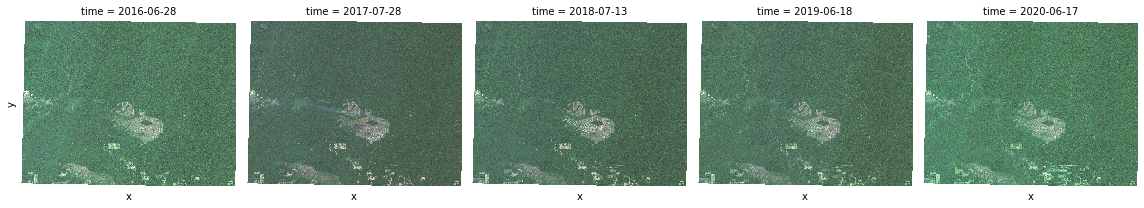

In [7]:
true_color_aggs = [
    ms.true_color(x.sel(band="red"), x.sel(band="green"), x.sel(band="blue"))
    for x in data
]

true_color = xr.concat(true_color_aggs, dim=data.coords["time"])

# visualize
t = true_color.plot.imshow(x="x", y="y", col="time", col_wrap=5)

### NDVI

Use Xarray-Spatial's [ndvi](https://xarray-spatial.org/reference/_autosummary/xrspatial.multispectral.ndvi.html) function to calculate NDVI. Compute the NDVI for each year's image:

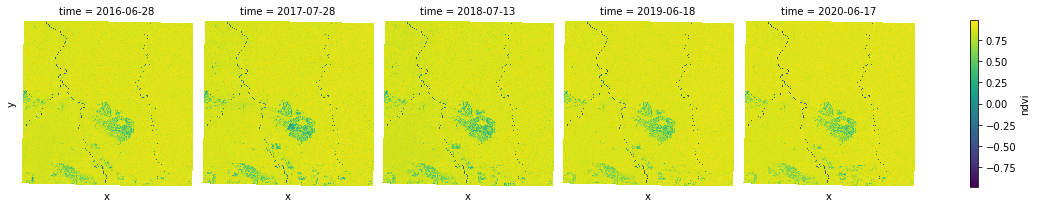

In [8]:
ndvi_aggs = [ms.ndvi(x.sel(band="nir"), x.sel(band="red")) for x in data]

ndvi = xr.concat(ndvi_aggs, dim="time")

ndvi.plot.imshow(x="x", y="y", col="time", col_wrap=5, cmap="viridis");

### Smoothing Images with Focal Mean

To smooth or reduce noise in an image, use the [focal.mean](https://xarray-spatial.org/reference/_autosummary/xrspatial.focal.mean.html) function. This function conducts a mean reduction to each 3x3 window in an image.

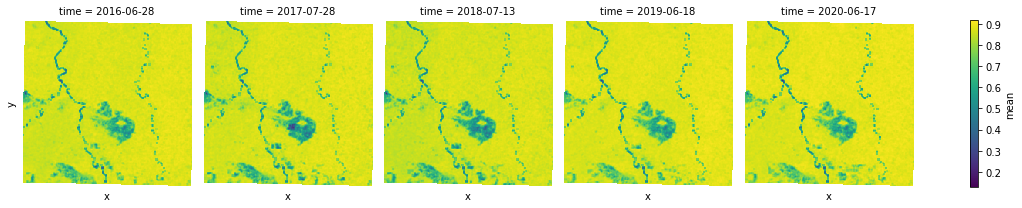

In [9]:
mean_aggs = [mean(ndvi_agg) for ndvi_agg in ndvi_aggs]

smooth = xr.concat(mean_aggs, dim="time")

s = smooth.plot.imshow(x="x", y="y", col="time", col_wrap=5, cmap="viridis")

### Focal statistics

In this step, calculate [focal statistics](https://xarray-spatial.org/user_guide/focal.html) using a circular kernel for the NDVI data arrays computed above. By default, seven statistics are computed:

1. Mean
2. Max
3. Min
4. Range
5. Std
6. Var
7. Sum

The result of `focal_stats` is a 3D `DataArray` with the newly added `stats` dimension. The size of the kernel will affect the result of `focal_stats`. Use `cacl_cellsize` to determine an appropriate kernel size. 

In this example, each pixel represents a region of 500 m by 500 m. Consider a circular kernel with a radius of 1.5 km, which equals three times the input cell size.

In [10]:
cellsize = calc_cellsize(ndvi)
cellsize

(500.0, 500.0)

In [11]:
kernel = circle_kernel(*cellsize, radius=3 * cellsize[0])
kernel.shape

(7, 7)

In [12]:
%%time
stats_aggs = [focal_stats(ndvi_agg, kernel) for ndvi_agg in ndvi_aggs]

stats = xr.concat(stats_aggs, dim="time")

CPU times: user 528 ms, sys: 2 ms, total: 530 ms
Wall time: 513 ms


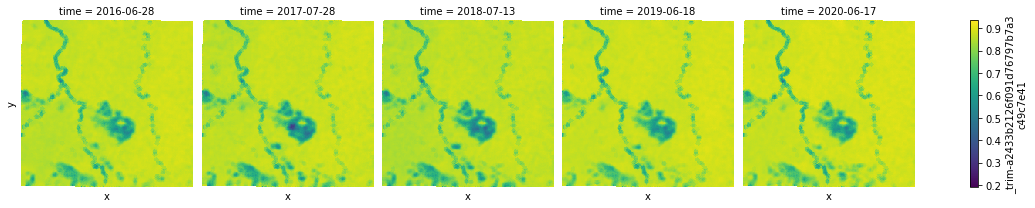

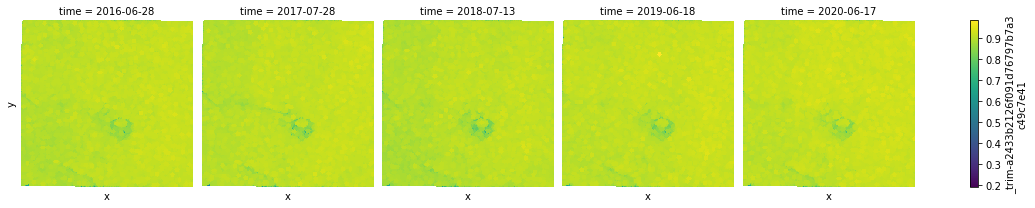

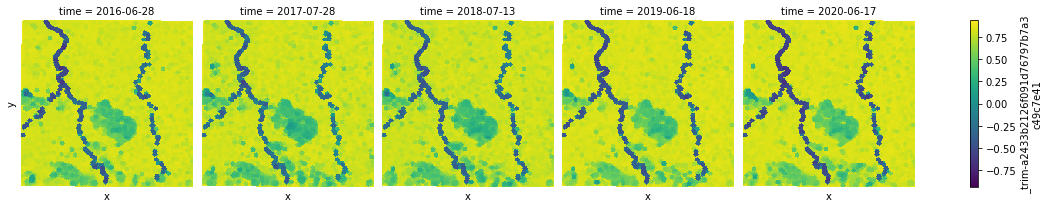

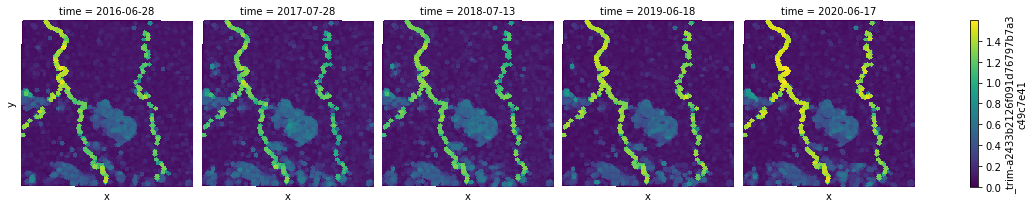

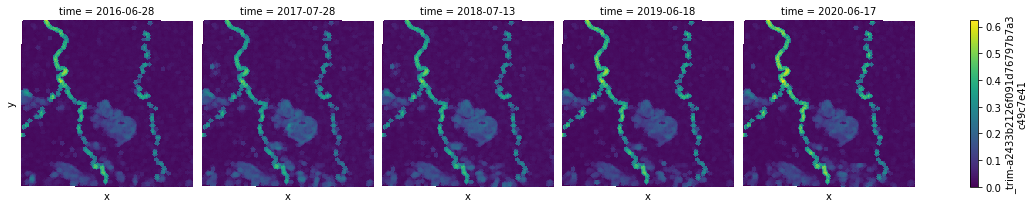

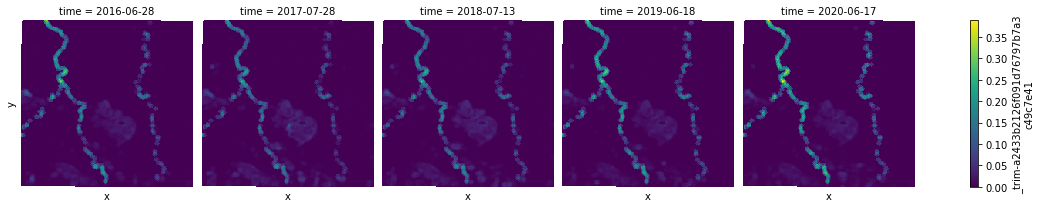

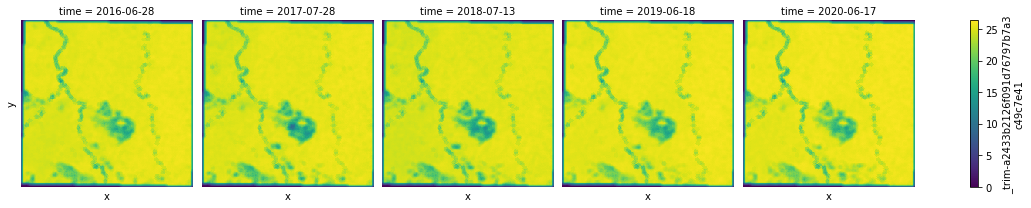

In [13]:
# transpose the data array so `stats` dimension appears first
stats_t = stats.transpose("stats", "time", "y", "x")

for stats_img in stats_t:
    g = stats_img.plot.imshow(x="x", y="y", col="time", col_wrap=5, cmap="viridis")

### Custom statistics

Sometimes you may want to compute a different statistic than the options provided in `focal_stats`, or you may want to apply a custom kernel to your images. That's when Xarray-Spatial's [convolution_2d](https://xarray-spatial.org/reference/_autosummary/xrspatial.convolution.convolution_2d.html?highlight=convolution_2d) might come in handy. For all inner cells of an array, this function calculates the 2D convolution of each cell. Convolution is frequently used for image processing, such as smoothing, sharpening, and edge detection of images by eliminating spurious data or enhancing features in the data.

As an example, use a horizontal [Sobel](https://en.wikipedia.org/wiki/Sobel_operator) kernel:

In [14]:
# Use Sobel operator
sobel_kernel = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])

sobel_kernel

array([[ 1,  0, -1],
       [ 2,  0, -2],
       [ 1,  0, -1]])

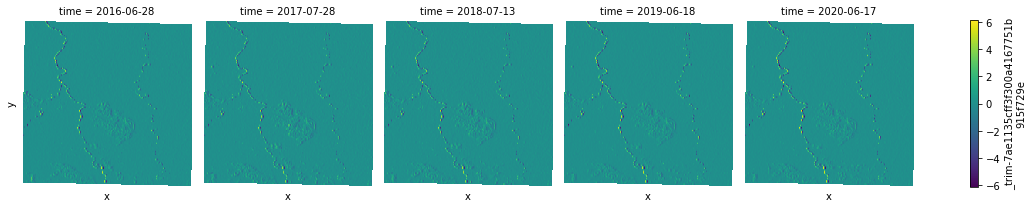

In [15]:
sobel_aggs = [convolution_2d(ndvi_agg, sobel_kernel) for ndvi_agg in ndvi_aggs]

sobel_agg = xr.concat(sobel_aggs, dim="time")

sobel_agg.plot.imshow(x="x", y="y", col="time", col_wrap=5, cmap="viridis");

### Hotspots
 
Use the [hotspots](https://xarray-spatial.org/reference/_autosummary/xrspatial.focal.hotspots.html) function of Xarray-Spatial to identify hot and cold spots in a DataArray. A statistically significant hot spot has a high value and is surrounded by other high values. A cold spot has a low value and is surrounded by other low values.

Similar to other focal tools, to identify hot and cold spots, you need to provide a kernel as a NumPy ndarary, along with the input data array to be analyzed. The output array will have one of seven possible values for each pixel of the input array:

- -99 for 99% confidence low value cluster (cold spot)
- -95 for 95% confidence low value cluster (cold spot)
- -90 for 90% confidence low value cluster (cold spot)
- 0 for no significance
- +90 for 90% confidence high value cluster (hot spot)
- +95 for 95% confidence high value cluster (hot spot)
- +99 for 99% confidence high value cluster (hot spot)

Hotspots are identified using z-scores of all cells in an input raster. This requires a global mean to be defined. Currently, `focal.hotspots` does not perform well in terms of finding the nan-mean of a Dask-backed data array. Therefore, use a numpy-backed version for this:

In [16]:
%%time
hotspots_aggs = [hotspots(ndvi_agg, kernel) for ndvi_agg in ndvi]

hotspots_ndvi = xr.concat(hotspots_aggs, dim="time")

CPU times: user 166 ms, sys: 3.13 ms, total: 169 ms
Wall time: 161 ms


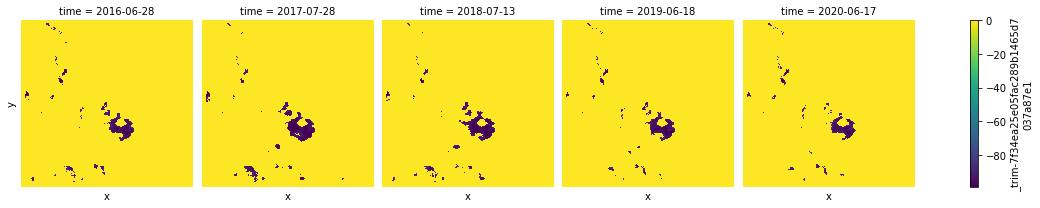

In [17]:
hotspots_ndvi.plot.imshow(x="x", y="y", col="time", col_wrap=5, cmap="viridis");

In [18]:
np.unique(hotspots_ndvi)

array([-99, -95, -90,   0], dtype=int8)

None of the results above are positive. This means that there are only cold spots detected for this region. These cold spots have expanded roughly from 2017 to 2018 and gradually decreased in size in 2020.

### Next steps

To find out more about Xarray-Spatial focal statistics and other toolsets provided by the library, see the [Xarray-Spatial website](https://xarray-spatial.org/index.html).

Click on this link to go to the next notebook: [07 Surface Tools](07_Surface_Tools.ipynb)